In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import shapiro, anderson, normaltest
from scipy.signal import find_peaks

## Генерация данных

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def generate_data(model, n=250):
    np.random.seed(42)

    if model == 'a1':
        data = np.random.normal(loc=20, scale=0.05, size=n)

    elif model == 'a2':
        data = np.random.beta(a=2, b=5, size=n) * 0.5
    
    elif model == 'b':
        data_b_normal = np.random.normal(loc=20, scale=0.05, size=int(n*0.6))
        data_b_unimodal = np.random.beta(a=2, b=5, size=int(n*0.4)) * 0.4 + 19.8
        data = np.concatenate([data_b_normal, data_b_unimodal])
    
    elif model == 'c1':
        data = np.random.normal(loc=0, scale=5, size=n)
    
    elif model == 'c2':
        data_c2_normal = np.random.normal(loc=0, scale=2, size=int(n*0.6))
        data_c2_unimodal = np.random.beta(a=2, b=5, size=int(n*0.4)) * 5 - 2.5
        data = np.concatenate([data_c2_normal, data_c2_unimodal])
    
    elif model == 'c3':
        t = np.linspace(0, 1, n)
        data = np.random.normal(loc=20 - 0.3 * t, scale=0.05, size=n)
    
    elif model == 'c4':
        levels = [30.05, 30.00, 29.95, 30.10, 29.90]
        block_lengths = [50, 100, 75, 125, 150]  
        data_c4_blocks = np.hstack([np.full(bl, lvl) for bl, lvl in zip(block_lengths, levels)])  
        noise = np.random.normal(loc=0, scale=0.02, size=len(data_c4_blocks))  
        data = data_c4_blocks + noise
            
    elif model == 'd':
        t = np.linspace(0, 1, n)
        data = 0.1 * t + np.random.normal(loc=20, scale=0.02, size=n)

    return data

In [17]:
def plot_data(model, data):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(data, marker='x', linestyle='-', color='green')
    plt.title(f'Временная диаграмма для модели {model}')

    plt.subplot(1, 2, 2)
    plt.hist(data, bins=15, alpha=0.7, color='green', edgecolor='black')
    plt.title(f'Гистограмма для модели {model}')

    plt.tight_layout()
    plt.show()

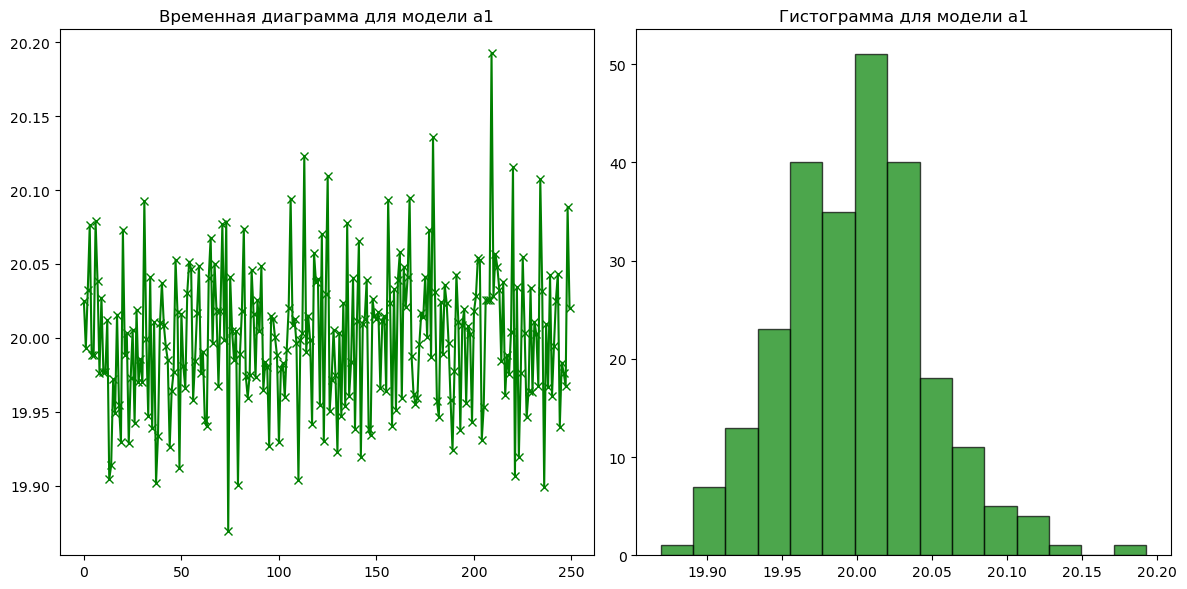

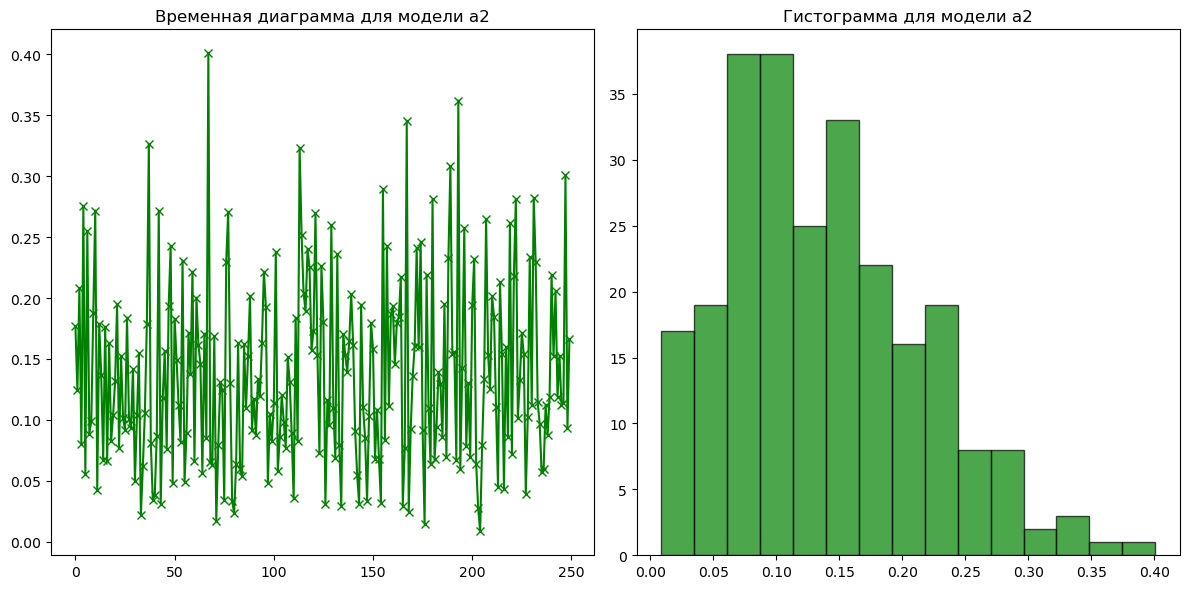

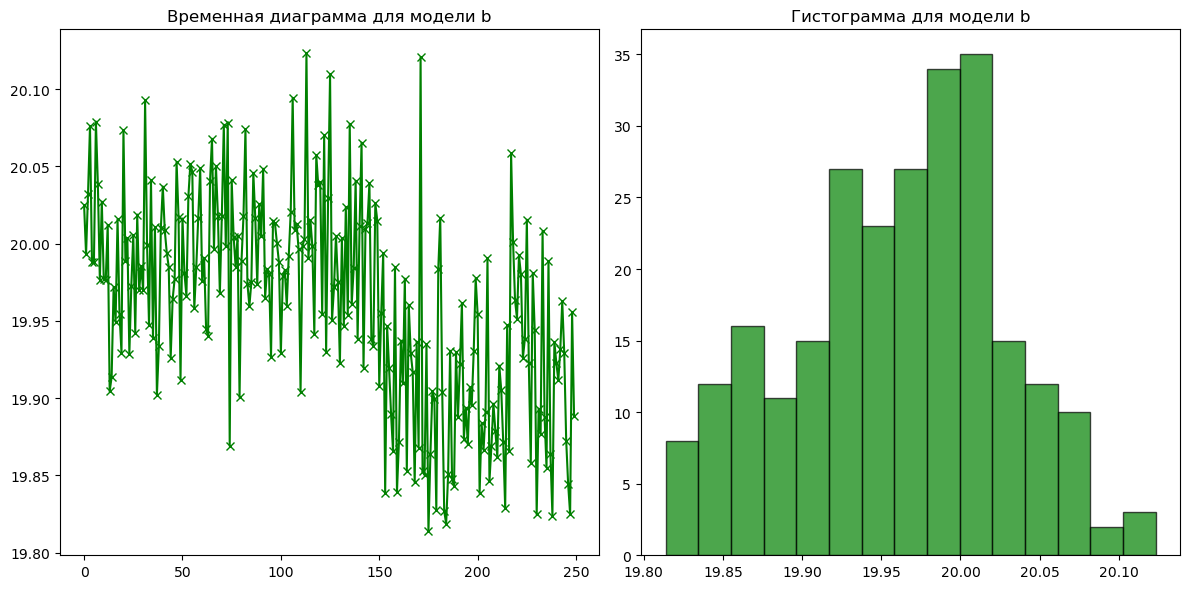

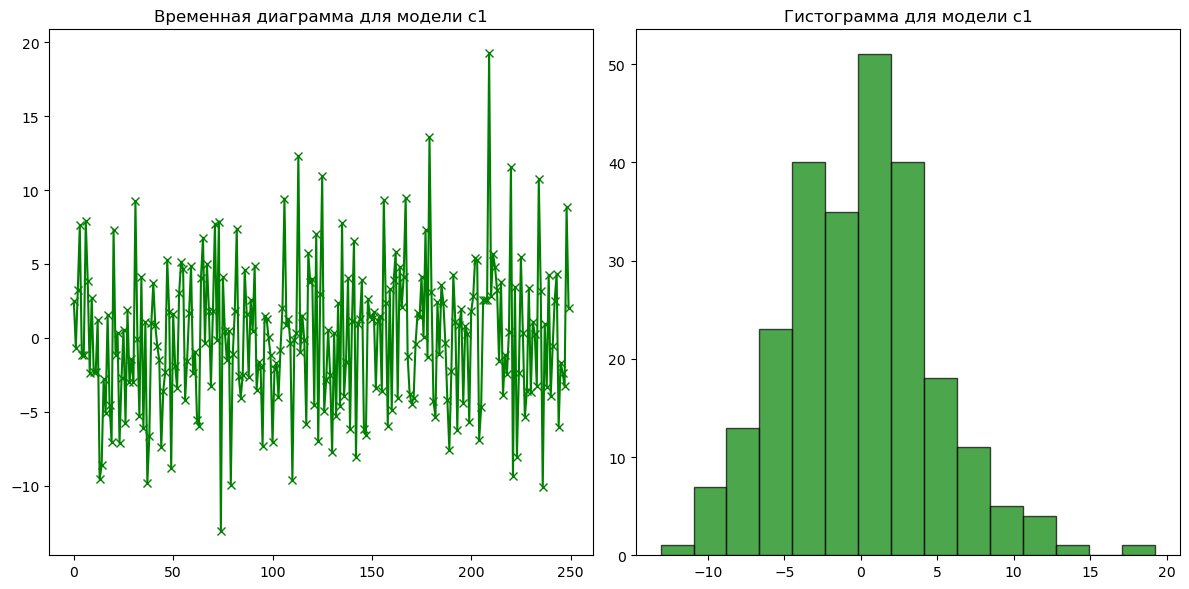

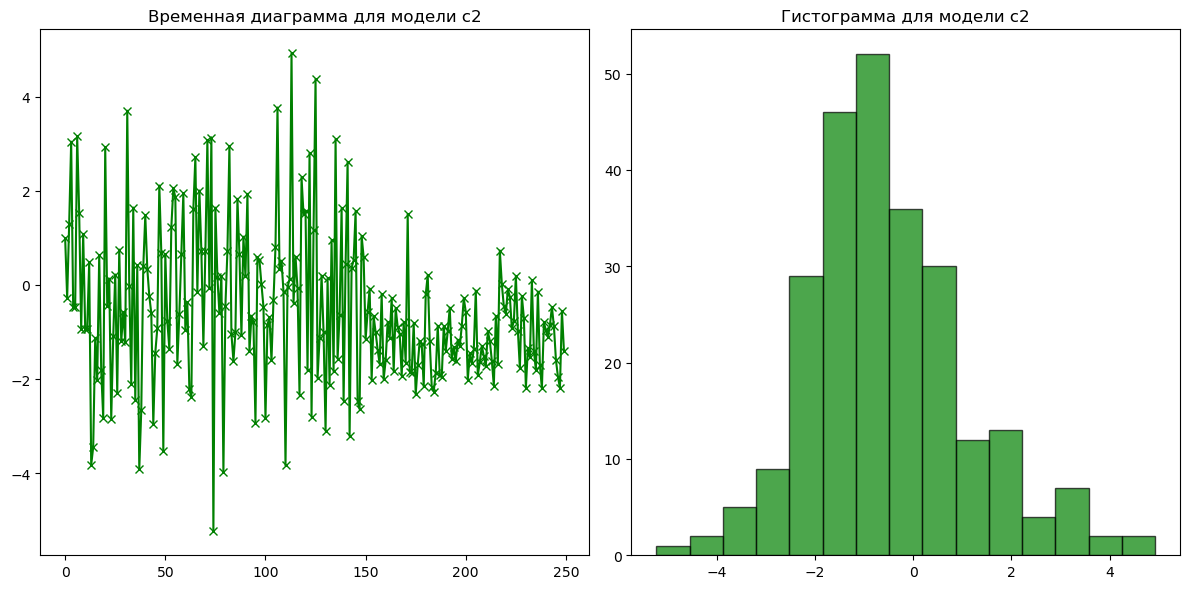

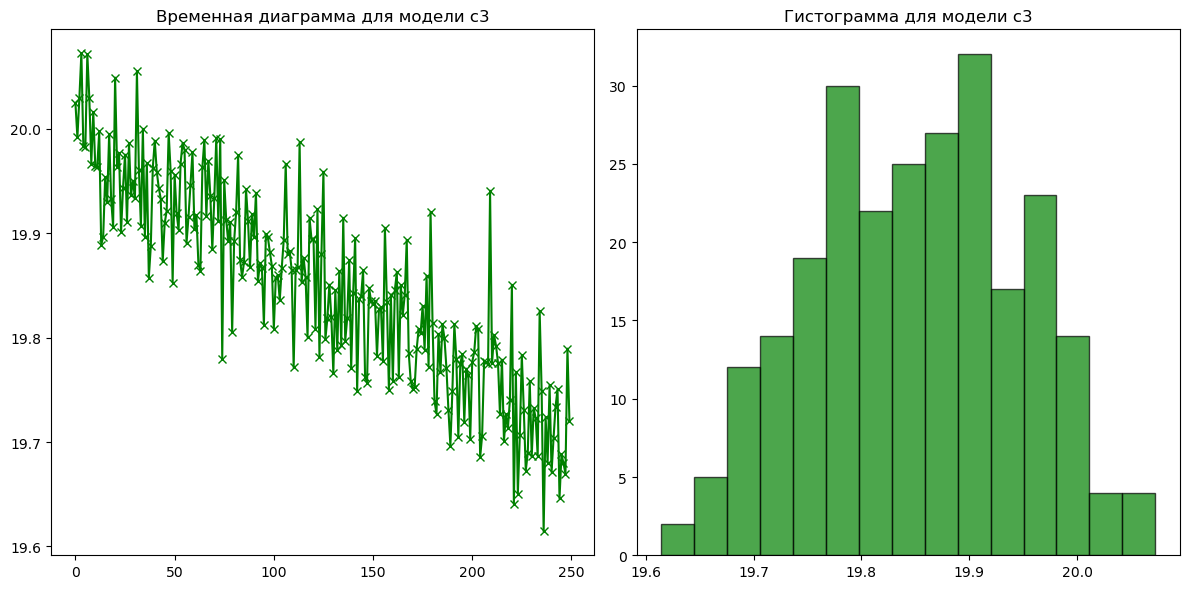

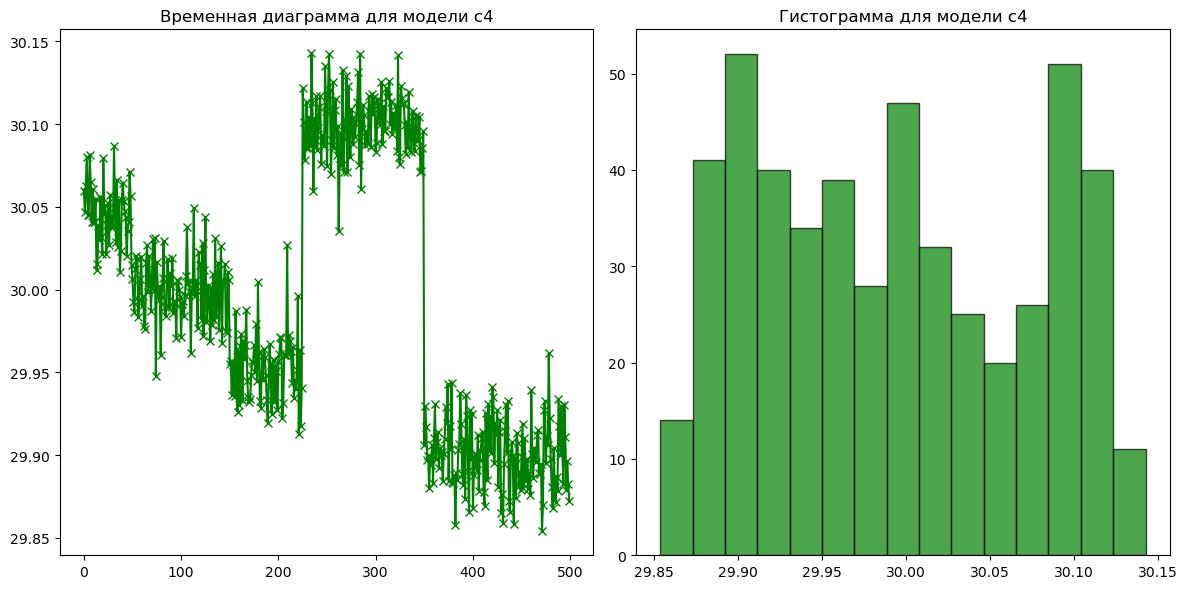

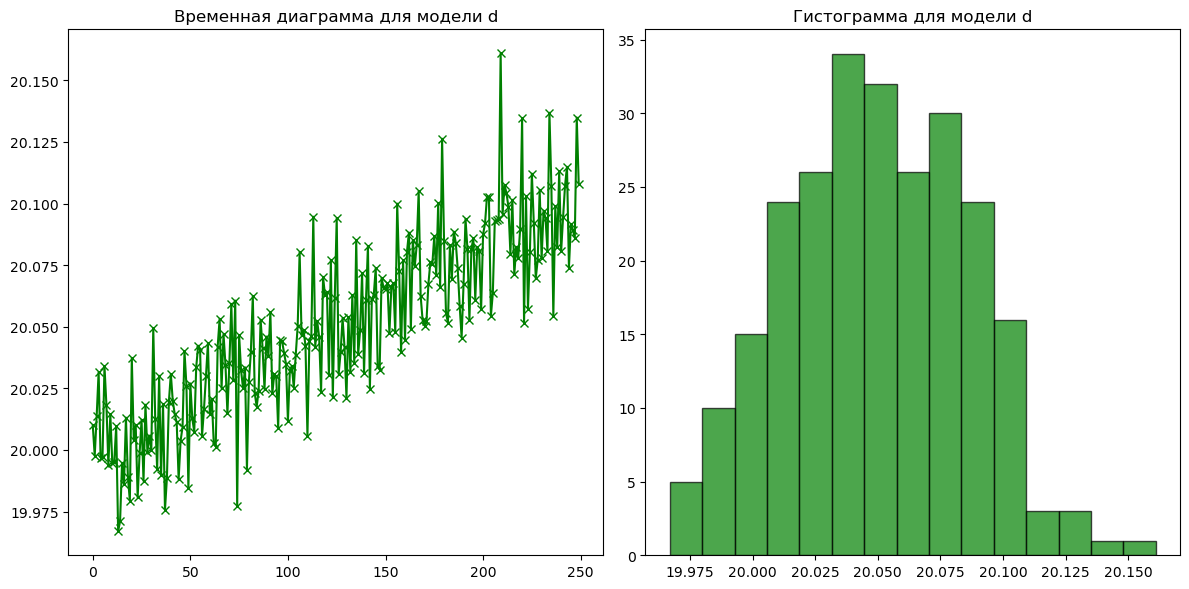

In [18]:
models = ['a1', 'a2', 'b', 'c1', 'c2', 'c3', 'c4', 'd']
for elem in models:
    data = generate_data(elem)
    plot_data(elem, data)

## Анализ положения и изменчивости

### Нормализация

In [19]:
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

### Функция для вычисления скользящего среднего

In [20]:
def get_mean(data, win_size):
    data = normalize_data(data)
    return np.convolve(data, np.ones(win_size)/win_size, mode='valid')

### Функция для вычисления стандартного отклонения

In [21]:
def get_std(data, win_size):
    data = normalize_data(data)
    return np.array([np.std(data[i:i+win_size]) for i in range(len(data) - win_size + 1)])

### Анализ параметров регрессии

In [22]:
def linregress_param(mean, std):
    x_mean_idx = np.arange(len(mean))
    x_std_idx = np.arange(len(std))

    #print(f"sizes: {mean.shape} | {x_mean_idx.shape}")
    #print(f"{x_mean_idx.ndim} | {x_std_idx.ndim}")

    if (len(x_mean_idx) == len(x_std_idx)):
        slope_mean, intercept_mean, r_value_mean, p_value_mean, std_err_mean = stats.linregress(x_mean_idx, mean)
        print(f"slope_mean={slope_mean} | intercept_mean={intercept_mean} | r_value_mean={r_value_mean} | p_value_mean={p_value_mean} | std_err_mean={std_err_mean}")
        slope_std, intercept_std, r_value_std, p_value_std, std_err_std = stats.linregress(x_std_idx, std)
        print(f"slope_std={slope_std} | intercept_std={intercept_std} | r_value_std={r_value_std} | p_value_std={p_value_std} | std_err_std={std_err_std}")


        if abs(slope_mean) < 0.01:
            mean_class = "Постоянное положение"
        elif abs(slope_mean) >= 0.01 and r_value_mean > 0.5:
            mean_class = "Систематическое положение"
        else:
            mean_class = "Случайное положение"

        if abs(slope_std) < 0.01:
            std_class = "Постоянная изменчивость"
        elif abs(slope_std) >= 0.01 and r_value_std > 0.5:
            std_class = "Систематическая изменчивость"
        else:
            std_class = "Случайная изменчивость"

    else:
        print("Размеры массивов mean | std не совпадают")

    return mean_class, std_class

### Параметры регрессии

#### Постоянные данные

In [23]:
constant_data = np.ones(100) * 10 + np.random.normal(0, 0.05, 100)

constant_mean_class, constant_std_class = linregress_param(get_mean(constant_data, 10), get_std(constant_data, 10))

slope_mean=0.00042805919620490367 | intercept_mean=0.5885211337685465 | r_value_mean=0.21023193672969834 | p_value_mean=0.045481427169049425 | std_err_mean=0.00021100571864429701
slope_std=-0.0012312629363641346 | intercept_std=0.20880163351271686 | r_value_std=-0.6681561113230031 | p_value_std=4.639831275131152e-13 | std_err_std=0.00014533262421569817


#### Систематические данные

In [24]:
systematic_data = np.arange(100) * 0.1 + np.random.normal(0, 0.05, 100)

systematic_mean_class, systematic_std_class = linregress_param(get_mean(systematic_data, 10), get_std(systematic_data, 10))

slope_mean=0.010154961247991095 | intercept_mean=0.045351381212754394 | r_value_mean=0.999981603600541 | p_value_mean=4.0022204025449605e-199 | std_err_mean=6.529360878088869e-06
slope_std=-2.9674940957037593e-06 | intercept_std=0.02962838617406852 | r_value_std=-0.04191258310368438 | p_value_std=0.6932363547875702 | std_err_std=7.498400661722124e-06


#### Случайные данные

In [25]:
random_data = np.random.normal(0, 1, 100)

random_mean_class, random_std_class = linregress_param(get_mean(random_data, 10), get_std(random_data, 10))

slope_mean=-0.0007265746040118291 | intercept_mean=0.4492227695106468 | r_value_mean=-0.4056439389774367 | p_value_mean=6.63484052553206e-05 | std_err_mean=0.00017354065383519478
slope_std=-0.00041109728962277414 | intercept_std=0.1869249278080346 | r_value_std=-0.2579683071219609 | p_value_std=0.013557420111993197 | std_err_std=0.00016320344946223303


## Необходимо корректировать пороговые значения и условия классификации в linregress_param

## ----------------------------------------------------------------------------------
## Анализ мгновенного и результирующего распределений

In [26]:
def get_distrib(data):
    hist, bin_edges = np.histogram(data, bins=15)
    peaks, _ = find_peaks(hist)

    if len(peaks) == 1:

        stat, p_value = shapiro(data)
        if p_value > 0.05:
            return "normal"
        
        result = anderson(data)
        if result.statistic < result.critical_values[2]:  
            return "normal"
        
        stat, p_value = normaltest(data)
        if p_value > 0.05:
            return "normal"
        
        return "unimodal"
    
    else:
        return "another"

In [27]:
def get_distrib_class(data, inst_coef):
    inst_data = data[-int(len(data)*inst_coef):]

    return get_distrib(inst_data), get_distrib(data)

In [28]:
const_inst, const_res = get_distrib_class(constant_data, 0.1)
print(f"const data: {const_inst} | {const_res}")

sys_inst, sys_res = get_distrib_class(systematic_data, 0.1)
print(f"system data: {sys_inst} | {sys_res}")

rand_inst, rand_res = get_distrib_class(random_data, 0.1)
print(f"random data: {rand_inst} | {rand_res}")

const data: another | another
system data: another | another
random data: another | another
